In [64]:
import math
import os
import re

import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import signal
from tqdm.notebook import tqdm


from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

## load M4 data

In [2]:
df_hourly = pd.read_csv("../m4_data/Hourly-train.csv")
print("hourly read: {}".format(df_hourly.shape))
df_daily = pd.read_csv("../m4_data/Daily-train.csv")
print("daily read: {}".format(df_daily.shape))
df_weekly = pd.read_csv("../m4_data/Weekly-train.csv")
print("weekly: {}".format(df_weekly.shape))
df_monthly = pd.read_csv("../m4_data/Monthly-train.csv")
print("monthly: {}".format(df_monthly.shape))
df_quarterly = pd.read_csv("../m4_data/Quarterly-train.csv")
print("quarterly: {}".format(df_quarterly.shape))
df_yearly = pd.read_csv("../m4_data/Yearly-train.csv")
print("yearly: {}".format(df_yearly.shape))

df_m4 = pd.concat([df_hourly,
                   df_daily,
                   df_weekly,
                    df_monthly,
                   df_quarterly,
                   df_yearly])

df_hourly = None
df_daily = None
df_weekly = None
df_monthly = None
df_quarterly = None
df_yearly = None

hourly read: (414, 961)
daily read: (4227, 9920)
weekly: (359, 2598)
monthly: (48000, 2795)
quarterly: (24000, 867)
yearly: (23000, 836)


## load UCR data

In [5]:
ts_train_infos = []
ts_test_infos = []
for root, dirs, files in os.walk("../data/ucr_data/UCRArchive_2018/"):
    for name in files:
        if(name.endswith("_TRAIN.tsv")):
            path_tmp = os.path.join(root,name)
            ts_name = re.split("/", root)[-1]
            ts_train_infos.append((ts_name, os.path.join(root,name)))
        elif(name.endswith("_TEST.tsv")):
            path_tmp = os.path.join(root,name)
            ts_name = re.split("/", root)[-1]
            ts_test_infos.append((ts_name, os.path.join(root,name)))

In [7]:
df_ucr_train = pd.DataFrame()
df_ucr_test = pd.DataFrame()

for ts_info in tqdm(ts_train_infos):
    ts_name = ts_info[0]
    fp = ts_info[1]
    
    df_tmp = pd.read_csv(fp, sep='\t', header=None)
    df_tmp['name'] = ts_name
    df_tmp['no'] = df_tmp.index
    cols = df_tmp.columns.tolist()
    cols = cols[-2:] + cols[:-2]
    df_tmp = df_tmp[cols]
    df_ucr_train = df_ucr_train.append(df_tmp)
    
for ts_info in tqdm(ts_test_infos):
    ts_name = ts_info[0]
    fp = ts_info[1]
    
    df_tmp = pd.read_csv(fp, sep='\t', header=None)
    df_tmp['name'] = ts_name
    df_tmp['no'] = df_tmp.index
    cols = df_tmp.columns.tolist()
    cols = cols[-2:] + cols[:-2]
    df_tmp = df_tmp[cols]
    df_ucr_test = df_ucr_test.append(df_tmp)
    

print("df_train shape: {}".format(df_ucr_train.shape))
print("df_test shape: {}".format(df_ucr_test.shape))

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

NameError: name 'df_train' is not defined

## get average length of series

In [12]:
df_ucr_train.head()

,name,no,0,1,2,3,4,5,6,7,...,2835,2836,2837,2838,2839,2840,2841,2842,2843,2844
0,Haptics,0,5,-1.047477,0.548336,-0.259562,-1.581216,-1.915218,-1.278188,-0.691525,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Haptics,1,2,-1.018153,0.514133,-0.097370,-1.374493,-1.957364,-1.567188,-0.906353,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Haptics,2,4,-1.183382,0.339636,0.045998,-1.080209,-1.934357,-1.972025,-1.412721,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Haptics,3,3,-0.896969,0.186145,0.578290,0.392361,-0.157240,-0.818047,-1.374046,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Haptics,4,5,-1.009424,0.614673,-0.397552,-1.766144,-1.906942,-1.145026,-0.717200,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
def get_length_m4(s: pd.Series) -> pd.Series:
    return s.iloc[1:].dropna().shape[0]

def get_length_ucr(s: pd.Series) -> pd.Series:
    return s.iloc[3:].dropna().shape[0]

In [14]:
tqdm.pandas()
m4_ts_len = df_m4.progress_apply(func=get_length_m4, axis=1)
ucr_train_ts_len = df_ucr_train.progress_apply(func=get_length_ucr, axis=1)

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/64306 [00:00<?, ?it/s]

In [20]:
ucr_train_ts_len.head()

0    1092
1    1092
2    1092
3    1092
4    1092
dtype: int64

In [140]:
b_m4 = int(math.floor(math.log(len(m4_ts_len), 2)))

b_ucr_train = int(math.floor(math.log(len(ucr_train_ts_len), 2)))
# stats
mean_m4 = str(round(m4_ts_len.mean(),1))
mean_m4_str = r"$\displaystyle \mu="+mean_m4+"$"
median_m4 = str(m4_ts_len.median())
median_m4_str = r"$\displaystyle \tilde{x}="+median_m4+"$"
mode_m4 = str(m4_ts_len.mode().values[0])
mode_m4_str = r"$\displaystyle Mo="+mode_m4+"$"
std_m4 = str(round(m4_ts_len.std(),1))
std_m4_str = r"$\displaystyle \sigma="+std_m4+"$"
min_m4 = str(m4_ts_len.min())
max_m4 = str(m4_ts_len.max())
range_m4 = r"$\displaystyle range= ["+min_m4+","+max_m4+"]$"

stats_m4 = mean_m4_str+"\n"+median_m4_str+"\n"\
+mode_m4_str+"\n"+std_m4_str+"\n"+range_m4

mean_ucr= str(round(ucr_train_ts_len.mean(),1))
mean_ucr_str = r"$\displaystyle \mu="+mean_ucr+"$"
median_ucr = str(ucr_train_ts_len.median())
median_ucr_str = r"$\displaystyle \tilde{x}="+median_ucr+"$"
mode_ucr = str(ucr_train_ts_len.mode().values[0])
mode_ucr_str = r"$\displaystyle Mo="+mode_ucr+"$"
std_ucr = str(round(ucr_train_ts_len.std(),1))
std_ucr_str = r"$\displaystyle \sigma="+std_ucr+"$"
min_ucr = str(ucr_train_ts_len.min())
max_ucr = str(ucr_train_ts_len.max())
range_ucr = r"$\displaystyle range= ["+min_ucr+","+max_ucr+"]$"

stats_ucr = mean_ucr_str+"\n"+median_ucr_str+"\n"\
+mode_ucr_str+"\n"+std_ucr_str+"\n"+range_ucr

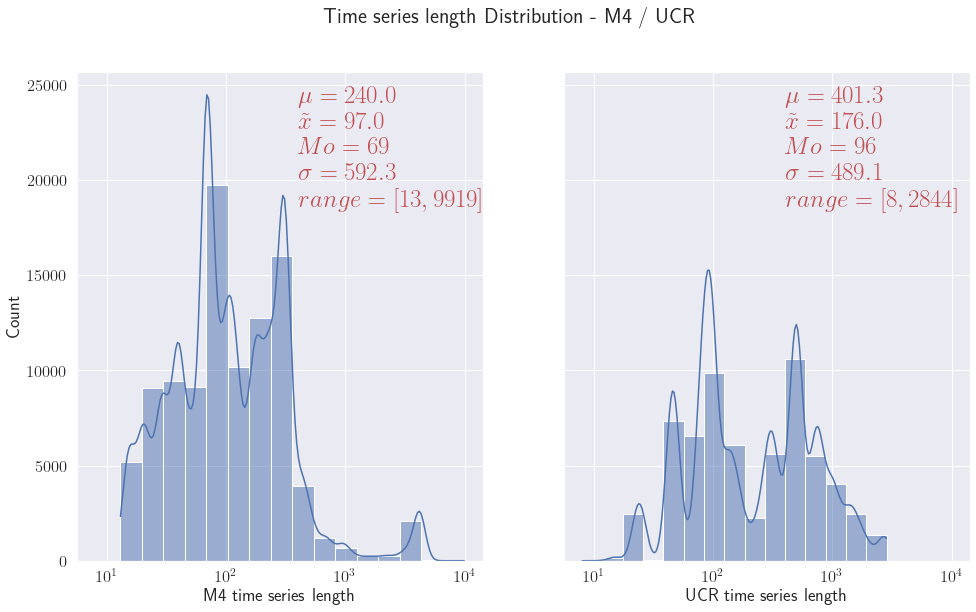

In [ ]:
sns.set(font_scale=1.5)

fig, axs = plt.subplots(1,2, figsize=(16,9), sharey=True, sharex=True)
#fig.tight_layout()
sns.histplot(data=m4_ts_len, bins=b_m4, kde=True,
             log_scale=True, ax=axs.flatten()[0]);
axs.flatten()[0].set_xlabel("M4 time series length")
sns.histplot(data=ucr_train_ts_len, bins=b_ucr_train, kde=True,
              log_scale=True, ax=axs.flatten()[1]);
axs.flatten()[1].set_xlabel("UCR time series length");
axs.flatten()[0].text(10**2.6, 18.6*10**3,
                      stats_m4, color='r',
                     fontsize=25)
axs.flatten()[1].text(10**2.6, 18.6*10**3,
                    stats_ucr, color='r',
                     fontsize=25)
fig.suptitle("Time series length Distribution - M4 / UCR");
fig.savefig("../img/ts_m4_ucr_length.png")

## Boxplot of length distribtuion

In [159]:
df_m4 = pd.DataFrame({
    'repo':['M4']*m4_ts_len.size,
    'len': m4_ts_len
})

df_ucr = pd.DataFrame({
    'repo':['UCR']*ucr_train_ts_len.size,
    'len': ucr_train_ts_len
})

df_ln = pd.concat([df_m4, df_ucr])
df_ln.tail()

,repo,len
395,UCR,80
396,UCR,80
397,UCR,80
398,UCR,80
399,UCR,80


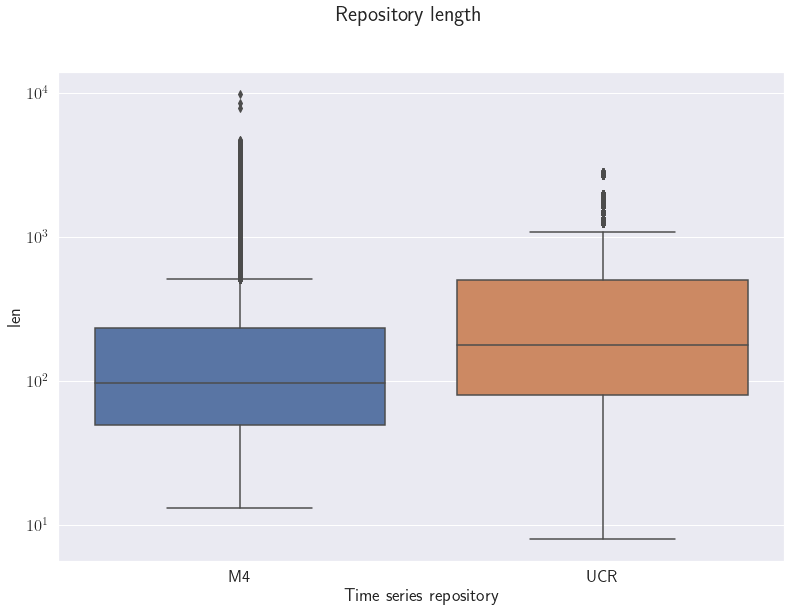

In [165]:
fig, ax = plt.subplots(figsize=(13,9))

sns.boxplot(data=df_ln, y='len', x='repo', ax=ax)
ax.set_yscale('log')
ax.set_xlabel('Time series repository')
plt.suptitle('Repository length')
fig.savefig("../img/ts_len_m4_ucr_boxp.png")